<h1 style="text-align: center;">CS 6476 - Computer Vision </h1>
<h2 style="text-align: center;">Problem Set 6 - Particle Tracking</h2>

In [1]:
import numpy as np
import cv2

import copy as cp
import matplotlib.pyplot as plt
from PIL import Image
import sys

In [46]:
class PFTracker:    
    def __init__(self,model,frame,x_model,y_model,width,height,win_width,win_height,n_particles=100,std_mse=10,std_dyn=20,
                alpha=0.1):
        self.n_particles = n_particles
        """ init particles uniformly around model location significantly improve precision in comparison with all particles
        at model location
        """
        self.particles=np.array([[x,y]for x,y in zip(np.random.uniform(x_model-win_width/2,x_model+win_width/2,n_particles),
                                            np.random.uniform(y_model-win_width/2,y_model+win_height/2,n_particles))]).astype(
        np.float)
        self.count = 0
        self.width = width
        self.height = height
        self.std_mse = std_mse
        self.std_dyn = std_dyn
        self.win_width = win_width
        self.win_height = win_height
        self.weights = [1/self.n_particles for k in np.arange(self.n_particles)]
        print(len(self.weights))
        print(self.particles.shape)
        print(self.n_particles)
        self.x_c,self.y_c=0,0
        # save colored frame in memory to display results in color
        self.current_frame = cp.deepcopy(frame)
        self.current_frame_gray = cv2.cvtColor(cp.deepcopy(frame), cv2.COLOR_BGR2GRAY)
        # Tracked object
        self.model = cv2.cvtColor(cp.deepcopy(model), cv2.COLOR_BGR2GRAY)
        self.alpha = alpha
        
    def __MSE(self,im1,im2):
        """cf formula in ps description part 1"""
        im1 = cp.deepcopy(im1)
        im2 = cp.deepcopy(im2)
        # if size of window == 0 kill the particle
        if(im2.shape[0]<=0 or im2.shape[1]<=0):
            return sys.maxsize
        #images sizes check before subtract
        if(im1.shape[0] != im2.shape[0] or im1.shape[1] != im2.shape[1] ):
            im1 = cv2.resize(im1,(im2.shape[1],im2.shape[0]))
        mse = np.mean(np.square(np.subtract(im1,im2)))
        return mse
    
    def getWindow(self,im,x,y):
        # avoid side effects
        minx,maxx = max(0,x-self.win_width//2),min(self.width,x+self.win_width//2)
        miny,maxy = max(0,y-self.win_height//2),min(self.height,y+self.win_height//2)
        return im[miny:maxy,minx:maxx]

    
    def predict(self):
        # predict next state of each particle
        self.particles += np.random.normal(0, self.std_dyn,self.n_particles*2).reshape(self.particles.shape)


    def measure(self):
        #get particles windows
        particles_win = [self.getWindow(self.current_frame_gray,particle[0],particle[1]) 
                         for particle in self.particles.astype(np.int)]
        #update weights
        self.weights = [np.exp(-self.__MSE(self.model,cand_window)/2/(self.std_mse**2)) for cand_window in particles_win]
        #normalize weights
        self.weights /= np.sum(self.weights)

    
    def resample(self):
        """particles sampling"""
        leftovers = np.random.choice(self.n_particles, size=self.n_particles, replace=True, p=self.weights)
        self.particles = self.particles[leftovers]
        self.weights = self.weights[leftovers]
    
    def estimate(self):
        self.x_c = np.average(self.particles[:,0],weights=self.weights)
        self.y_c = np.average(self.particles[:,1],weights=self.weights)
        minx,maxx=max(0,int(self.x_c-self.win_width/2)),min(self.width,int(self.x_c+self.win_width/2+1))
        miny,maxy=max(0,int(self.y_c-self.win_height/2)),min(self.height,int(self.y_c+self.win_height/2+1))
        self.bestWin=np.array(self.current_frame_gray[miny:maxy,minx:maxx])
        if(self.alpha!=0):
            # this is ugly but necessary
            if(self.bestWin.shape[0]!=self.model.shape[0] or self.bestWin.shape[1]!=self.model.shape[1]):
                self.bestWin=cv2.resize(self.bestWin,(self.model.shape[1],self.model.shape[0]))
            self.model = np.add(self.alpha*self.bestWin.astype(np.float),(1-self.alpha)*self.model.astype(np.float))
        
    
    def update(self,frame):
        if(self.count%30==0):
            print("frame n°",self.count)
        self.current_frame = cp.deepcopy(frame)
        self.current_frame_gray = cv2.cvtColor(cp.deepcopy(frame), cv2.COLOR_BGR2GRAY)
        self.count +=1
        self.predict()
        self.measure()
        self.resample()
        self.estimate()
        self.draw_info()
        return self.get_current_frame()
    
    
    
    def draw_info(self):
        self.draw_particles()
        self.draw_box()
        self.draw_coordinates()
    
    def draw_coordinates(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(self.current_frame,str(int(self.x_c))+' '+str(int(self.y_c)),(10,500), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    def draw_particles(self):
        for p in self.particles:
            cv2.circle(self.current_frame,(int(p[0]),int(p[1])), 5, (0,0,255), -1)
        return
    
    def draw_box(self):
        cv2.rectangle(self.current_frame,tuple((int(self.x_c-self.win_width/2),int(self.y_c-self.win_height/2))),
                      tuple((int(self.x_c+self.win_width/2),int(self.y_c+self.win_height/2))),color=(255,0,0), thickness=5)
    def get_current_frame(self):
        return self.current_frame
        

In [27]:
def tracker(stream_src,model_src,std_dyn=1,std_mse=150,n_particles=200,alpha=0):
    cap = cv2.VideoCapture(stream_src)
    # first frame
    ret, frame = cap.read()
    # if can't load first frame exit
    if not ret:
        print("cannot load first frame")
        return
    
    frames_out = []

    # get model coordinates
    f = open(model_src,"r")
    print(f)
    minx,miny,w,h = f.readline().split()
    minx,w = int(float(minx)),int(float(w))
    miny,h = int(float(miny)),int(float(h))
    maxx = minx + w
    maxy = miny + h
    x_model,y_model=int(minx+w/2),int(miny+h/2)
    # get model
    model = frame[miny:maxy,minx:maxx]
    
    frames_out.append(model)
    #init the particle filter
    tracker = PFTracker(model=model,frame=frame,x_model=x_model,y_model=y_model,width=frame.shape[1],height=frame.shape[0],
                        win_width=w,win_height=h,n_particles=n_particles,std_mse=std_mse,std_dyn=std_dyn,alpha=alpha)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("cannot load frame")
            break
        frames_out.append(tracker.update(frame))
    return frames_out

def display_frames(frames):
    plt.figure(figsize=(50,50))
    n_rows = len(frames)
    k=1
    for frame in frames:
        plt.subplot(n_rows,1,k),plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        k+=1
    plt.show()

In [22]:
frames = tracker('pres_debate.avi','pres_debate.txt',std_dyn=8,std_mse=5,n_particles=200)


<_io.TextIOWrapper name='pres_debate.txt' mode='r' encoding='cp1252'>
200
(200, 2)
200
frame n° 0
frame n° 10
frame n° 20
frame n° 30
frame n° 40
frame n° 50
frame n° 60
frame n° 70
frame n° 80
frame n° 90
frame n° 100
frame n° 110
frame n° 120
frame n° 130
frame n° 140
frame n° 150
frame n° 160
frame n° 170
frame n° 180
frame n° 190
frame n° 200
frame n° 210
frame n° 220
frame n° 230
frame n° 240
frame n° 250
frame n° 260
frame n° 270
frame n° 280
frame n° 290
frame n° 300
frame n° 310
cannot load frame


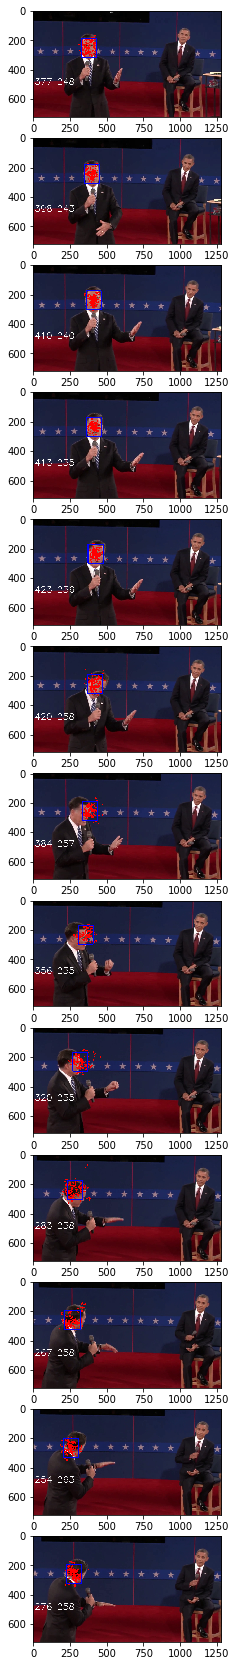

In [23]:
display_frames(frames[1:250:20])

In [47]:
#need good input file to work
frames_hand=tracker('pres_debate.avi','pres_debate_hand.txt',std_dyn=10,std_mse=2,n_particles=100,alpha=0.1)

<_io.TextIOWrapper name='pres_debate_hand.txt' mode='r' encoding='cp1252'>
100
(100, 2)
100
frame n° 0
frame n° 30
frame n° 60
frame n° 90
frame n° 120
frame n° 150
frame n° 180
frame n° 210
frame n° 240
frame n° 270
frame n° 300
cannot load frame


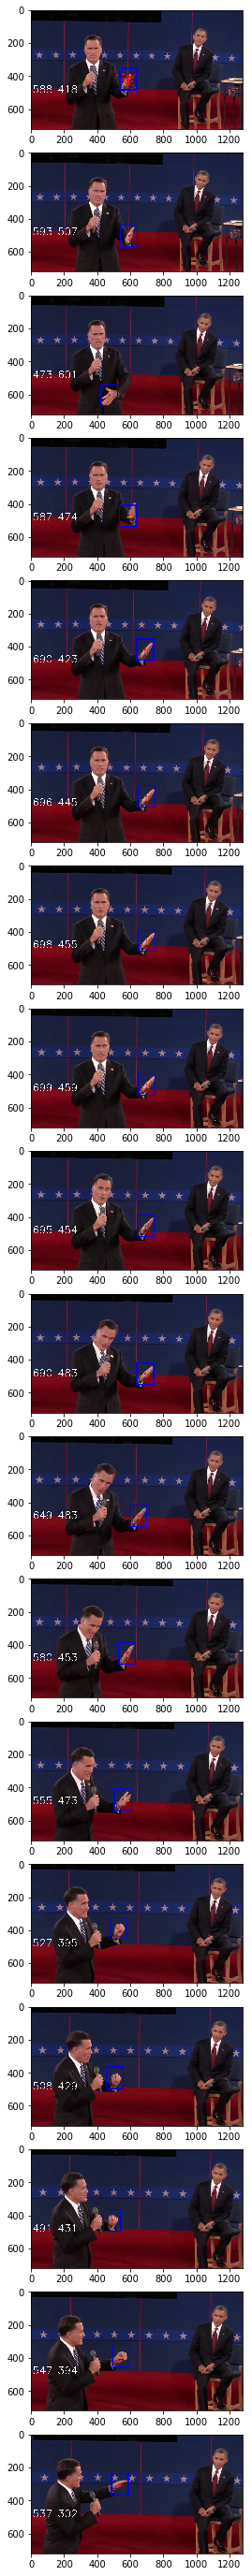

In [50]:
display_frames(frames_hand[1:180:10])

In [29]:
frames_hand2=tracker('pres_debate.avi','pres_debate_hand.txt',std_dyn=10,std_mse=2,n_particles=100,alpha=0.1)

<_io.TextIOWrapper name='pres_debate_hand.txt' mode='r' encoding='cp1252'>
100
(100, 2)
100
frame n° 0
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
frame n° 10
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
frame n° 20
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)

(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
frame n° 210
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
frame n° 220
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
frame n° 230
(129, 103)
best win shape: (130, 104)
(129, 103)
best win shape: (130, 104)
(129, 103)


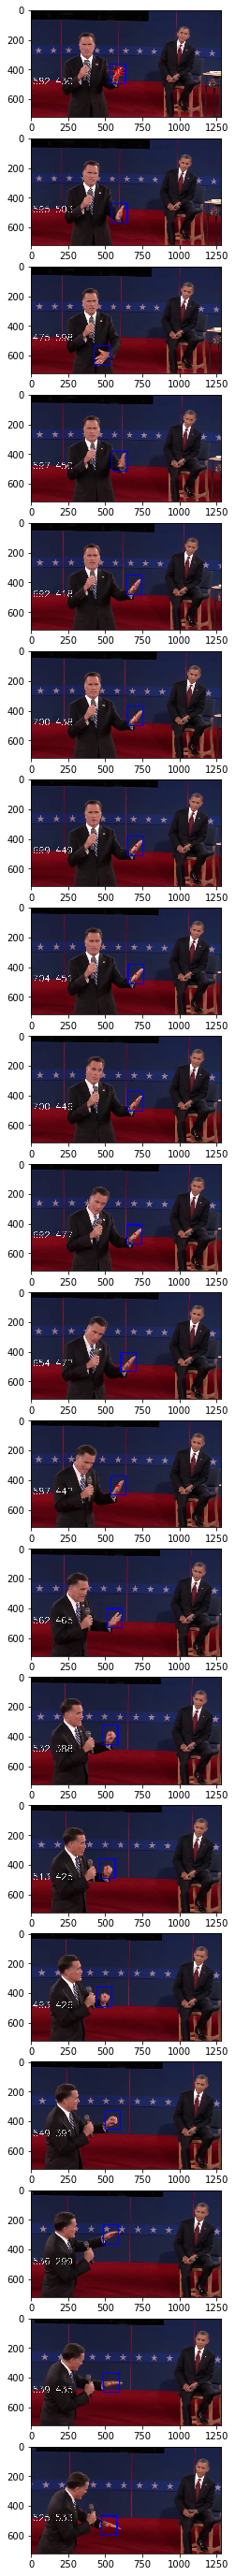

In [30]:
display_frames(frames_hand2[1:200:10])

In [38]:
#need lots of particles because of the noise
frames_hand2=tracker('noisy_debate.avi','pres_debate_hand.txt',std_dyn=10,std_mse=4,n_particles=400,alpha=0.1)

<_io.TextIOWrapper name='pres_debate_hand.txt' mode='r' encoding='cp1252'>
400
(400, 2)
400
frame n° 0
frame n° 10
frame n° 20
frame n° 30
frame n° 40
frame n° 50
frame n° 60
frame n° 70
frame n° 80
frame n° 90
frame n° 100
frame n° 110
frame n° 120
frame n° 130
frame n° 140
frame n° 150
frame n° 160
frame n° 170
frame n° 180
frame n° 190
frame n° 200
frame n° 210
frame n° 220
frame n° 230
frame n° 240
frame n° 250
frame n° 260
frame n° 270
frame n° 280
frame n° 290
frame n° 300
frame n° 310
frame n° 320
frame n° 330
frame n° 340
frame n° 350
frame n° 360
frame n° 370
frame n° 380
frame n° 390
frame n° 400
frame n° 410
frame n° 420
frame n° 430
frame n° 440
frame n° 450
frame n° 460
frame n° 470
frame n° 480
frame n° 490
frame n° 500
frame n° 510
frame n° 520
frame n° 530
frame n° 540
cannot load frame


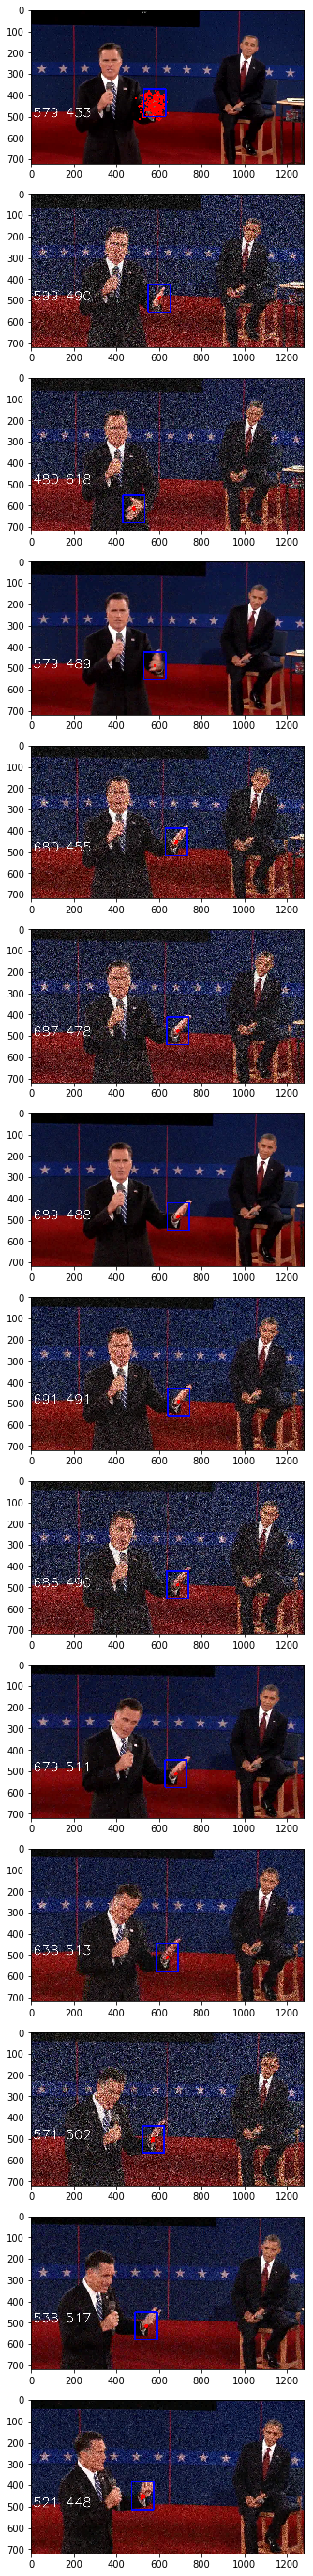

In [43]:
display_frames(frames_hand2[1:140:10])